In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from Incompressible_flow_1d.flow_sim import compute_solution

In [2]:
N = 2000
x = torch.rand(N).requires_grad_(True)
t = 3 * torch.rand(N).requires_grad_(True)

simulation_data = torch.empty((N, 5))
for i in trange(N):
    simulation_data[i, :] = torch.tensor(compute_solution(t[i].detach().numpy(), x[i].detach().numpy())[1:])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.10it/s]


In [4]:
simulation_data.requires_grad_(True)

tensor([[9.2785e-01, 8.3498e-01, 1.6502e-01, 5.6331e-01, 5.9924e-05],
        [6.6161e-01, 4.9988e-30, 1.0000e+00, 9.4883e-21, 9.4883e-02],
        [9.9776e-01, 1.0000e+00, 0.0000e+00, 5.5933e-01, 5.5926e-42],
        ...,
        [4.7286e-01, 5.8619e-01, 4.1381e-01, 3.7352e-01, 3.1875e-03],
        [1.4874e-01, 6.3866e-01, 3.6134e-01, 4.7831e-01, 1.9992e-03],
        [5.3674e-01, 5.8227e-01, 4.1773e-01, 3.6020e-01, 3.2348e-03]],
       requires_grad=True)

In [5]:
model_points = torch.stack((t, x), -1)
press0_points = torch.stack((t, torch.zeros(N)), -1)
press1_points = torch.stack((t, torch.ones(N)), -1)
s0_points = torch.stack((torch.zeros(N), x), -1)
model_points

tensor([[2.4688, 0.0981],
        [0.0444, 0.3027],
        [2.3856, 0.0040],
        ...,
        [0.5950, 0.5998],
        [1.3147, 0.8753],
        [0.5341, 0.5423]], grad_fn=<StackBackward0>)

In [6]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 2, hidden_layer = 50, number_layers = 3, output_layer = 5):
        super().__init__()
        
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        """
        Функция для обновления нейронной сети
        
        Возвращаемое значения
        x - вектор (давление, насыщ. воды, насыщ. нефти, 
        скор. расхода воды, скор. расхода нефти)
        """
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

Вспомогательные данные для одномерной задачи

\begin{equation}
    \begin{cases}
        r_1(t, x) = 0.1 \frac{\partial s_{\text{water}}(t, x)}{\partial t} + \frac{\partial u_{water}(t, x)}{\partial x} = 0 \\
        r_2(t, x) = 0.1 \frac{\partial s_{\text{oil}}(t, x)}{\partial t} + \frac{\partial u_{oil}(t, x)}{\partial x} = 0 \\
        r_3(t, x) = u_{\text{water}} + s_{\text{water}}^2 \frac{\partial P(t, x)}{\partial x} = 0 \\
        r_4(t, x) = u_{\text{oil}} + \frac{0.1 s_{\text{oil}}^4}{3} \frac{\partial P(t, x)}{\partial x} = 0 \\
        r_5(t, x) = s_{\text{water}}(t, x) + s_{\text{oil}}(t, x) - 1 = 0 \\
    \end{cases}
\end{equation}

Начальные условия
\begin{equation}
    \begin{cases}
        P(t, 0) = 1 \\
        P(t, 1) = 0 \\
        s_{\text{water}}(0, x) = 0.0 \\
        s_{\text{oil}}(0, x) = 1.0 \\
    \end{cases}
\end{equation}


Функции потерь:

\begin{equation}
    \label{eq:loss_term_0}
    \mathcal{R}_0(t, x) = r_1(t, x)^2 + r_2(t, x)^2 + r_3(t, x)^2 + r_4(t, x)^2 + r_5(t, x)^2
\end{equation}


\begin{equation}
    \label{eq:loss_term_1}
    \mathcal{R}_1(t, x) = \big(p(t, 0) - 1.0\big)^2 + \big(p(t, 1) - 0.0 \big)^2 + \big( s_{\text{oil}}(0, x) - 1.0 \big)^2 + \big( s_{\text{water}}(0, x) - 0.0 \big)^2
\end{equation}

\begin{split}
        \mathcal{R}_2(t, x) = \big( p_{\text{neural network}}(t, x) - p_{\text{simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{water, neural network}}(t, x) - s_{\text{water, simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)\big)^2 + \\ + |u_{\text{water, neural network}}(t, x) - u_{\text{water, simulation}}(t, x)|^2 + \\ + |u_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)|^2
\end{split}

Итоговый лосс:

\begin{equation}
    \label{eq:loss_final}
    \mathcal{L} = w_0 \frac{1}{N} \mathcal{R}_0(t_i, x_i) + w_1 \frac{1}{N} \mathcal{R}_1(t_i, x_i) + w_2 \frac{1}{N} \mathcal{R}_2(t_i, x_i)
\end{equation}

In [7]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [8]:
def compute_loss_weights_simple(loss_grad, loss_bound, loss_diff, nbatch=20000, kappa=1.0e1, eps=1.0e-6):
    w_grad = 1.0
    w_bound= 1.0
    w_diff = 1.0
    proj_bound = (0.0 + loss_bound).detach().numpy()
    loss_vvar = (0.0 + loss_grad).detach().numpy()
    # w_norm = w_norm / (1.0 + np.sqrt(nbatch) * kappa * proj_norm)
    # w_grad = w_grad / (1.0 + np.sqrt(nbatch) * kappa * proj_norm)
    # w_grad = w_grad / (1.0 + np.sqrt(nbatch) * kappa * loss_vvar)
    # w_grad = w_grad / max((1.0 + np.sqrt(nbatch) * kappa * proj_norm), (1.0 + np.sqrt(nbatch) * kappa * loss_vvar))
    w_bound = np.exp(-np.sqrt(nbatch) * kappa * proj_bound)
    w_grad = np.exp(-np.sqrt(nbatch) * kappa * max(proj_bound, loss_vvar))
    w_summ = w_grad + w_bound + w_diff
    w_grad = w_grad / w_summ
    w_diff = w_diff / w_summ
    w_bound = w_bound / w_summ
    return (w_grad, w_bound, w_diff)

In [9]:
epochs = 20000
optimizer.param_groups[0]['lr'] = 0.0007

for cur_epoch in range(epochs):
    optimizer.zero_grad()
    
    model_res = model(model_points).requires_grad_(True)
    press0 = model(press0_points)[:, 0].requires_grad_(True)
    press1 = model(press1_points)[:, 0].requires_grad_(True)
    swat = model(s0_points)[:, 1].requires_grad_(True)
    soil = model(s0_points)[:, 2].requires_grad_(True)
    one_vector = torch.ones_like(model_res[:, 0])
    # считаем функции r(t,x)
    r1 = 0.1 * torch.autograd.grad(model_res[:, 1], 
                                   t, one_vector, 
                                   create_graph=True)[0] + torch.autograd.grad(model_res[:, 3], 
                                                                               x, one_vector, 
                                                                               create_graph=True)[0]
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 2], 
                                   t, one_vector, 
                                   create_graph=True)[0] + torch.autograd.grad(model_res[:, 4], 
                                                                               x, one_vector, 
                                                                               create_graph=True)[0]
    
    r3 = model_res[:, 3] + (model_res[:, 1] ** 2) * (torch.autograd.grad(model_res[:, 0], 
                                                                         x, one_vector, 
                                                                         create_graph=True)[0])
    
    r4 = model_res[:, 4] + (0.1/3) * (model_res[:, 2] ** 4) * (torch.autograd.grad(model_res[:, 0], 
                                                                                   x, one_vector, 
                                                                                   create_graph=True)[0])
    
    r5 = model_res[:, 1] + model_res[:, 2] - one_vector
    
    # Loss0
    loss0 = torch.mean(r1**2 + r2**2 + r3**2 + r4**2 + r5**2).requires_grad_(True)
    
    # Loss1
    loss1 = torch.mean((press0 - one_vector)**2 + press1**2 + \
                       (soil - one_vector)**2 + swat**2).requires_grad_(True)
    
    # Loss2
    loss2 = torch.mean((model_res[:,0] - simulation_data[:,0])**2 + (model_res[:,1] - simulation_data[:,1])**2 + \
                       (model_res[:,2] - simulation_data[:,2])**2 + (model_res[:,3] - simulation_data[:,3])**2 + \
                       (model_res[:,4] - simulation_data[:,4])**2).requires_grad_(True)
    
    # итоговый функционал потерь
    loss = 0.35 * loss0 + 0.35 * loss1 + 0.4 * loss2
    loss.backward(retain_graph=True)
    
    optimizer.step()
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss:{float(loss.detach().numpy()),float(loss0.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy())}\t')

epoch: 0	loss:(2.0289597511291504, 1.2100247144699097, 2.807194709777832, 1.557332158088684)	
epoch: 250	loss:(0.020487025380134583, 0.0036159988958388567, 0.013272312469780445, 0.03644029051065445)	
epoch: 500	loss:(0.00867530982941389, 0.0030689602717757225, 0.002402404323220253, 0.01690082997083664)	
epoch: 750	loss:(0.005734305828809738, 0.002052855445072055, 0.0010129462461918592, 0.011653187684714794)	
epoch: 1000	loss:(0.0044705732725560665, 0.0014600723516196012, 0.0006093041738495231, 0.009365728124976158)	
epoch: 1250	loss:(0.0038834866136312485, 0.0012014871463179588, 0.00043518023448996246, 0.00827663205564022)	
epoch: 1500	loss:(0.0035092385951429605, 0.0009892381494864821, 0.0003249897563364357, 0.007623147219419479)	
epoch: 1750	loss:(0.003240416757762432, 0.0008247287478297949, 0.00025379651924595237, 0.0071573322638869286)	
epoch: 2000	loss:(0.0030498653650283813, 0.0007315786206163466, 0.00021498691057786345, 0.006796418223530054)	
epoch: 2250	loss:(0.0029131709598004

epoch: 18500	loss:(0.00038359471363946795, 0.0004911335418000817, 0.00016210469766519964, 0.00038740335730835795)	
epoch: 18750	loss:(0.00032510384335182607, 0.0004818496236111969, 6.845593452453613e-05, 0.00033124221954494715)	
epoch: 19000	loss:(0.0003211251168977469, 0.0004632128693629056, 7.744049798930064e-05, 0.0003297410730738193)	
epoch: 19250	loss:(0.00027772507746703923, 0.0004453711735550314, 1.206832894240506e-05, 0.00029405311215668917)	
epoch: 19500	loss:(0.00026692624669522047, 0.0004368987865746021, 5.902011707803467e-06, 0.00027986496570520103)	
epoch: 19750	loss:(0.0002628989750519395, 0.0004339285660535097, 3.53078553416708e-06, 0.00027447048341855407)	


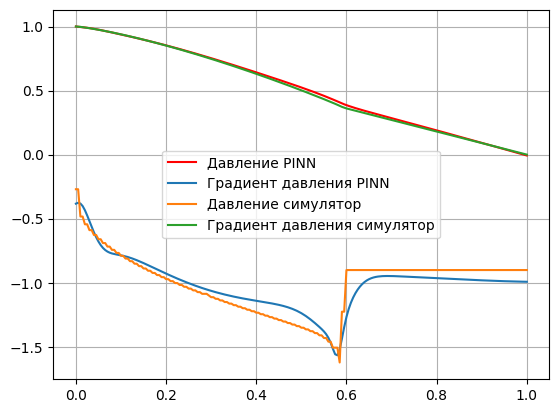

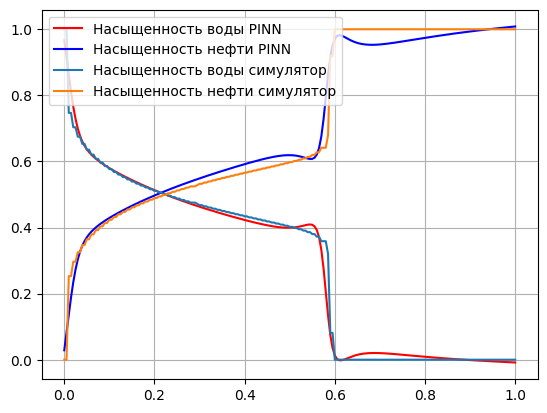

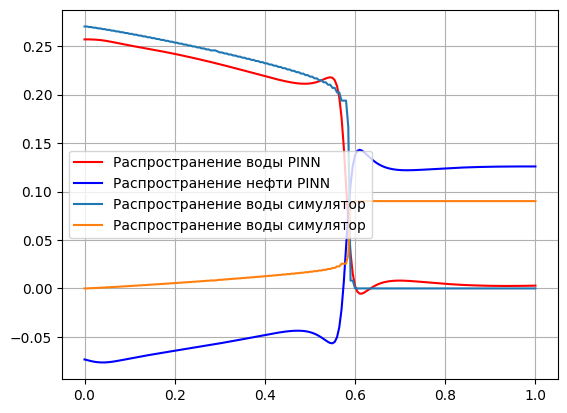

In [22]:
numx = 200
t_graph = 0.1 * torch.ones(numx + 1).requires_grad_(True)
x_graph = torch.linspace(0.0, 1.0, numx + 1).requires_grad_(True)

sample_points = torch.stack((t_graph, x_graph), -1)
 
result = model(sample_points)

pressure_grad = torch.autograd.grad(result[:, 0], x_graph, torch.ones_like(result[:, 0]))

plt.figure()
plt.plot(x_graph.detach().numpy(), result[:, 0].detach().numpy(), c='r', label='Давление PINN')
plt.plot(x_graph.detach().numpy(), pressure_grad[0].detach().numpy(), label='Градиент давления PINN')
plt.plot(x, pv, label='Давление симулятор')
plt.plot(x, pg, label='Градиент давления симулятор')
plt.grid()
plt.legend()
plt.savefig('press.png')
plt.show()


plt.figure()
plt.plot(x_graph.detach().numpy(), result[:, 1].detach().numpy(), c='r', label='Насыщенность воды PINN')
plt.plot(x_graph.detach().numpy(), result[:, 2].detach().numpy(), c='b', label='Насыщенность нефти PINN')
plt.plot(x, sw, label='Насыщенность воды симулятор')
plt.plot(x, so, label='Насыщенность нефти симулятор')
plt.grid()
plt.legend()
plt.savefig('swat_and_soil.png')
plt.show()

plt.figure()
plt.plot(x_graph.detach().numpy(), result[:, 3].detach().numpy(), c='r', label='Распространение воды PINN')
plt.plot(x_graph.detach().numpy(), result[:, 4].detach().numpy(), c='b', label='Распространение нефти PINN')
plt.plot(x, uw, label='Распространение воды симулятор')
plt.plot(x, uo, label='Распространение воды симулятор')
plt.grid()
plt.legend()
plt.savefig('uwat_and_uoil.png')
plt.show()

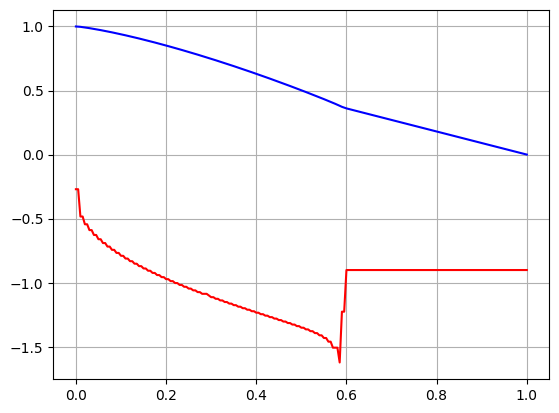

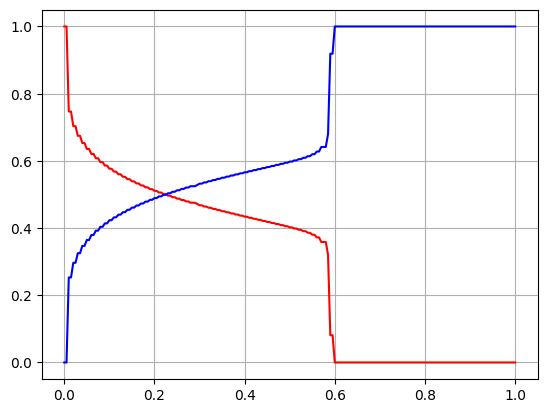

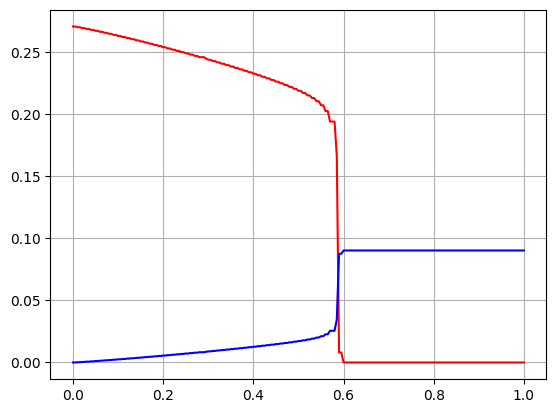

In [11]:
t = 0.1
x = 0.6

numx = 200
x = np.linspace(0.0, 1.0, numx + 1)
pv = 0.0 * x
pg = 0.0 * x
sw = 0.0 * x
so = 0.0 * x
uw = 0.0 * x
uo = 0.0 * x
for idx in range(numx + 1):
    press, pgrad, s_wat, s_oil, u_wat, u_oil = compute_solution(t, x[idx], nx=100)
    pv[idx] = press
    pg[idx] = pgrad
    sw[idx] = s_wat
    so[idx] = s_oil
    uw[idx] = u_wat
    uo[idx] = u_oil

plt.figure()
plt.plot(x, pv, c='r')
plt.plot(x, pg, c='b')
plt.grid()
plt.show()

plt.figure()
plt.plot(x, sw, c='r')
plt.plot(x, so, c='b')
plt.grid()
plt.show()

plt.figure()
plt.plot(x, uw, c='r')
plt.plot(x, uo, c='b')
plt.grid()
plt.show()

In [ ]:
# def compute_loss_weights_simple(loss_norm, loss_orth, loss_grad, nbatch, kappa=1.0e1, eps=1.0e-6):
#     w_orth = 1.0
#     w_norm = 1.0
#     w_grad = 1.0
#     proj_norm = (0.0 + loss_orth).cpu().detach().numpy()
#     loss_vvar = (0.0 + loss_norm).cpu().detach().numpy()
#     # w_norm = w_norm / (1.0 + np.sqrt(nbatch) * kappa * proj_norm)
#     # w_grad = w_grad / (1.0 + np.sqrt(nbatch) * kappa * proj_norm)
#     # w_grad = w_grad / (1.0 + np.sqrt(nbatch) * kappa * loss_vvar)
#     # w_grad = w_grad / max((1.0 + np.sqrt(nbatch) * kappa * proj_norm), (1.0 + np.sqrt(nbatch) * kappa * loss_vvar))
#     w_norm = np.exp(-np.sqrt(nbatch) * kappa * proj_norm)
#     w_grad = np.exp(-np.sqrt(nbatch) * kappa * max(proj_norm, loss_vvar))
#     w_summ = w_orth + w_norm + w_grad
#     w_orth = w_orth / w_summ
#     w_norm = w_norm / w_summ
#     w_grad = w_grad / w_summ
#     return (w_orth, w_norm, w_grad)

# # r1 r2 r5 сначала
# # r4 последние